# Estimating COVID-19's $R_t$ in Real-Time

> Original code by Kevin Systrom - April 17 ( *translated into Julia by Hugh Murrell April 2020* )

> Simplification to direct computation of $R_t$ without Baise by Hugh Murrell May 2020

> Some explanatory text by Kevin Systrom with comments by Hugh Murrell indented or in *italics*.

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When $R\gg1$, the pandemic will spread through a large part of the population. If $R_t<1$, the pandemic will slow quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation. In general, any $R_t<1$ means things are under control.

The value of $R_t$ helps us in two ways. (1) It helps us understand how effective our measures have been controlling an outbreak and (2) it gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.


In [1]:
using StatsBase, Distributions, Plots, DataFrames, CSV, Dates, HTTP, Impute, DSP;

### Connecting $I_t$ and $R_t$

Read accompanying article.


# Real-World Application to World Data

### Setup

We load World case data from OWID in csv format using this link:
https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/ecdc/full_data.csv
and then we filter the data, country by country, removing sections with missing data or zero new case counts.

We need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we apply a filter to the time series. The real world process is not nearly as stochastic as the actual reporting.

In [2]:
url="https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/ecdc/full_data.csv"
full_data = CSV.read(IOBuffer(HTTP.get(url).body))
println("table read, size = ",size(full_data))
println("latest counts on ",maximum(full_data[:,:date]))

table read, size = (17715, 6)
latest counts on 2020-05-17


### Adjustment for reporting delay

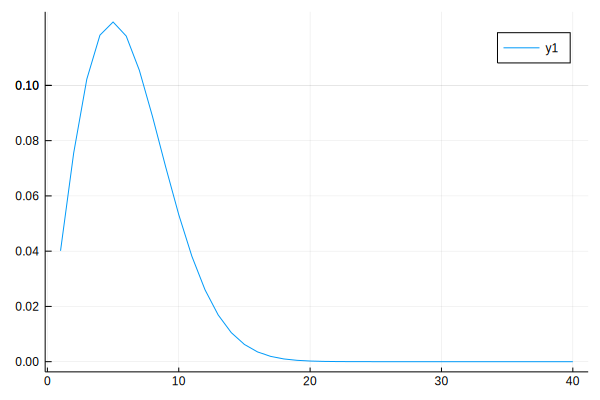

In [3]:
adj_range = collect(1:1:40)
p_delay = [pdf.(Weibull(2, 7),t) for t in adj_range]
p_delay = p_delay ./ sum(p_delay)
plot(adj_range, p_delay)

In [4]:
function estimate_onset(new_cases, p_delay)
    return reverse(conv(reverse(new_cases),p_delay))[length(p_delay):end]
end

estimate_onset (generic function with 1 method)

In [5]:
function adjust_onset(onset, p_delay)
    c_delay = cumsum(p_delay)
    extras = length(onset) - length(c_delay)
    if (extras > 0)
        cd = vcat(c_delay,ones(extras))
        adjusted = onset ./ reverse(cd)
    else
        adjusted = onset
    end
    return adjusted[1:end]
end

adjust_onset (generic function with 1 method)

In [6]:
# some model parameters that will be used throughout this notebook
IFP = 7   # infectious period in days
GAMMA = 1/IFP  # recovery rate
SMOOTHING_PASSES = 5 # number of times to apply moving average filter to case data
println("IFP=",IFP," GAMMA=",GAMMA," SMOOTHING_PASSES=",SMOOTHING_PASSES)

IFP=7 GAMMA=0.14285714285714285 SMOOTHING_PASSES=5


In [7]:
function moving_average(inf; alpha=0.5)
    vs = inf
    if length(vs) > 1
        ret = 
            # vcat( vs[1], [ alpha * vs[i] + (1 - alpha)*vs[i-1] for i = 2:length(vs) ] )
            vcat((vs[1]+2*vs[1])/3,
                   [sum(@view vs[i:(i+2)])/3 for i in 1:(length(vs)-(2))],
                    (2*vs[length(vs)]+vs[length(vs)])/3)
    else
        ret = vs
    end
    return ret
    return Int64.(round.(ret))
end

moving_average (generic function with 1 method)

In [8]:
function compute_infectives(new_cases) 
    onset = estimate_onset(new_cases,p_delay)
    adj_onset = adjust_onset(onset,p_delay)
    if length(adj_onset) >= IFP
       infects = [sum(adj_onset[i-IFP+1:i])
                        for i in IFP:length(adj_onset) ] 
    else
        infects = []
    end
    return infects
end

compute_infectives (generic function with 1 method)

In [9]:
function region_of_interest(data)
    nz = copy(data[data[:,:date] .> Date(2020,2,23),:])
    ind = findmax(reverse(diff(nz[:,:date])))[2]
    if (ind != 1)
        nz = copy(nz[size(nz)[1]-ind+2:end,:])
    end
    nz[ismissing.(nz[:,:new_cases]),:new_cases] .= 0
    # if (minimum(nz[:,:new_cases])<0)
    #     nz[:,:new_cases] = abs.(nz[:,:new_cases])
    # end
    smooth_new_cases = nz[:,:new_cases]
    for i in 1:SMOOTHING_PASSES
        smooth_new_cases = moving_average(smooth_new_cases)
    end
    nz[:,:new_cases] = Int64.(round.(smooth_new_cases))
    infectives = compute_infectives(smooth_new_cases)
    nz = nz[IFP:end,:]
    nz[:,:infectives] = Float64.(infectives)
    allowmissing!(nz)
    # now insert missing dates and impute infectives for those dates
    if size(nz)[1] > 1
        dr = nz[1,:date]:Day(1):nz[end,:date]
        for d in dr
            if ! (d in nz[:,:date])
                push!(nz,vcat(d, nz[1,:location], [missing for i in 1:size(nz)[2]-2]))
            end
        end
        sort!(nz)
        nz[!,:infectives] = Impute.interp(nz[:,:infectives])
    end
    return nz[nz[:,:infectives].>0,:]
end        

region_of_interest (generic function with 1 method)

(56, 7)
min = 1 max = 70 latest data at 2020-05-17


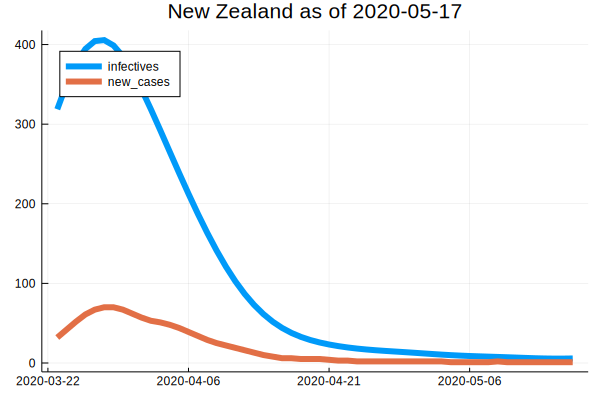

In [10]:
countries = unique(full_data[:,:location])
country = "New Zealand"
country_data = full_data[full_data[:,:location].==country,:]
country_data_filtered = region_of_interest(country_data)
println(size(country_data_filtered))
end_date = country_data_filtered[:,:date][end]
println("min = ",minimum(country_data_filtered[:,:new_cases]), 
        " max = ",maximum(country_data_filtered[:,:new_cases]),
        " latest data at ",end_date)
# smooth_infectives = country_data_filtered[:,:infectives]
# for count in 1:SMOOTHING_PASSES
#     smooth_infectives = moving_average(smooth_infectives) # gaussian_smoothing
# end
plot(country_data_filtered[:,:date], 
    [country_data_filtered[:,:infectives], country_data_filtered[:,:new_cases]], lw=6,
    legend=:topleft,
    labels=["infectives" "new_cases"],
    title="$country as of $end_date")

Putting all this into one function

In [11]:
function prepare_cases(full_data, country)
    country_data = full_data[full_data[:,:location].==country,:]
    if size(country_data)[1] < 30  # need at least one month of case counts
        return (country_data[:,:date], [], [], false)
    end
    country_data_filtered = region_of_interest(country_data)
    # smooth_infectives = country_data_filtered[:,:infectives]
    # for count in 1:SMOOTHING_PASSES
    #     smooth_infectives = moving_average(smooth_infectives) 
    # end
    # zeros_at = findall(x->x==0,infectives)
    # if ( length(zeros_at) == 0 )
    #     start = 1
    # else
    #     start = maximum(zeros_at)+1
    # end
    sanity_check = minimum(country_data[:,:new_cases]) >= 0
    return (country_data_filtered[:,:date],country_data_filtered[:,:infectives], 
        country_data_filtered[:,:new_cases], sanity_check)
end

prepare_cases (generic function with 1 method)

sane = true


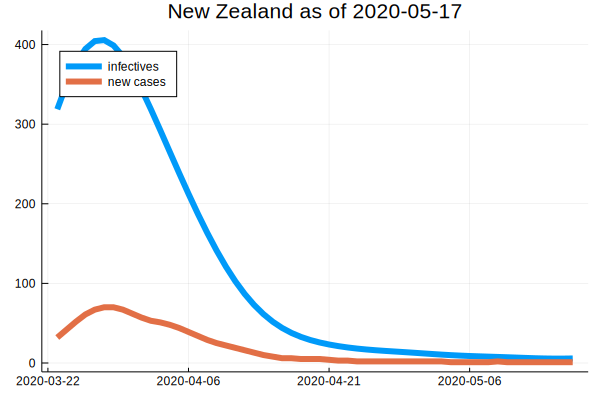

In [12]:
d,inf,newc,sane = prepare_cases(full_data,country)
println("sane = ",sane)
end_date = d[end]
plot(d, [inf, newc], lw=6,
    legend=:topleft,
    labels=["infectives" "new cases"],
    title="$country as of $end_date")

#### Now lets try and produce current most likely Rt for each country with enough case data

In [13]:
output_url = "../../HughMurrell.github.io/CoVmodel/RtLive/"
countries = unique(full_data[:,:location])
df = DataFrame(country=String[], start_date=Date[],end_date=Date[],
                    rt=Float64[],irat=Float64[],rank=Float64[])
for country in countries
    dates,infectives,new_cases,sane = prepare_cases(full_data,country)
    if ( ! sane || length(infectives)<10 || maximum(infectives) < 400)
        println("skipping $country ... sanity check is $sane")
    else
        println("processing $country ...")
        start_date = dates[1]  
        end_date = dates[end]
        # calculate ratio of last I(t) to maximum of all I(t)s
        irat = round(infectives[end]/maximum(infectives),digits=2)
        fig = plot(dates, [infectives, new_cases], lw=6,
            legend=:topleft,
            label=[ "infectious" "new_cases" ],
            title="$country,  I(t)/I(max) = $irat at $end_date")
        savefig(output_url*"plots/Inf_$country")
        rt_est = [ 1 + IFP * ((infectives[i+1]-infectives[i])/(infectives[i])) 
                            for i in 1:length(infectives)-1]
        last_week = rt_est[end-6:end]
        if maximum(last_week)-minimum(last_week) > 2
            println("something fishy, skipping $country anyway ...")
        else
            # make an Rt plot for this country
            rt_score = round(sum(rt_est[end:end]),digits=2)
            cdf = DataFrame(date = dates[2:end], rt = rt_est)
            fig = plot(cdf[:,:date], cdf[:,:rt], 
                lw = 3, label = "Rt estimate",
                m=:circle, ms=6, ylimits=[-0.5,5.5],
                title="$country, R(t) = $rt_score at $end_date")
            plot!(cdf[:,:date], ones(size(cdf)[1]),lw=3,label="R(t)=1")
            savefig(output_url*"plots/Rt_$country")
            # now save last mlrt, low, high, irat and rank
            rank = round(rt_score * irat, digits=2)
            push!(df,
                [country start_date end_date rt_score irat rank]
            )
        end
    end
end
df

processing Afghanistan ...
skipping Albania ... sanity check is true
processing Algeria ...
skipping Andorra ... sanity check is true
skipping Angola ... sanity check is true
skipping Anguilla ... sanity check is true
skipping Antigua and Barbuda ... sanity check is true
processing Argentina ...
processing Armenia ...
skipping Aruba ... sanity check is true
processing Australia ...
processing Austria ...
processing Azerbaijan ...
skipping Bahamas ... sanity check is true
processing Bahrain ...
processing Bangladesh ...
skipping Barbados ... sanity check is true
processing Belarus ...
processing Belgium ...
skipping Belize ... sanity check is true
skipping Benin ... sanity check is true
skipping Bermuda ... sanity check is true
skipping Bhutan ... sanity check is true
processing Bolivia ...
skipping Bonaire Sint Eustatius and Saba ... sanity check is true
skipping Bosnia and Herzegovina ... sanity check is true
skipping Botswana ... sanity check is true
processing Brazil ...
skipping Br

,country,start_date,end_date,rt,irat,rank
,String,Date,Date,Float64,Float64,Float64
1,Afghanistan,2020-03-20,2020-05-17,-0.46,0.52,-0.24
2,Algeria,2020-03-19,2020-05-17,1.05,1.0,1.05
3,Argentina,2020-03-20,2020-05-17,1.11,1.0,1.11
4,Armenia,2020-03-19,2020-05-17,1.36,1.0,1.36
5,Australia,2020-03-01,2020-05-17,1.12,0.05,0.06
6,Austria,2020-03-01,2020-05-17,1.28,0.1,0.13
7,Azerbaijan,2020-03-19,2020-05-17,1.36,1.0,1.36
8,Bahrain,2020-03-11,2020-05-17,0.58,0.85,0.49
9,Bangladesh,2020-03-23,2020-05-17,0.96,0.99,0.95


In [14]:
println(countries)

["Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Anguilla", "Antigua and Barbuda", "Argentina", "Armenia", "Aruba", "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bermuda", "Bhutan", "Bolivia", "Bonaire Sint Eustatius and Saba", "Bosnia and Herzegovina", "Botswana", "Brazil", "British Virgin Islands", "Brunei", "Bulgaria", "Burkina Faso", "Burundi", "Cambodia", "Cameroon", "Canada", "Cape Verde", "Cayman Islands", "Central African Republic", "Chad", "Chile", "China", "Colombia", "Comoros", "Congo", "Costa Rica", "Cote d'Ivoire", "Croatia", "Cuba", "Curacao", "Cyprus", "Czech Republic", "Democratic Republic of Congo", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Ethiopia", "Faeroe Islands", "Falkland Islands", "Fiji", "Finland", "France", "French Polynesia", "Gabon", "Gambia", "Georgia", "Germany", "Ghana",

In [15]:
dft = df
sort!(dft,:country)
CSV.write(output_url*"data/ranking_alpha.csv",dft)
sort!(dft,:rt)
CSV.write(output_url*"data/ranking_rt.csv",dft)
sort!(dft,:rank)
CSV.write(output_url*"data/ranking_rtirat.csv",dft)

"../../HughMurrell.github.io/CoVmodel/RtLive/data/ranking_rtirat.csv"

In [16]:
first(dft,6)

,country,start_date,end_date,rt,irat,rank
,String,Date,Date,Float64,Float64,Float64
1,Sudan,2020-03-20,2020-05-17,-0.64,0.43,-0.28
2,Afghanistan,2020-03-20,2020-05-17,-0.46,0.52,-0.24
3,Norway,2020-03-01,2020-05-17,-0.69,0.03,-0.02
4,Croatia,2020-03-18,2020-05-17,-0.17,0.06,-0.01
5,Iceland,2020-03-01,2020-05-17,-0.47,0.0,-0.0
6,New Zealand,2020-03-23,2020-05-17,1.23,0.01,0.01


In [17]:
maximum(dft[:,:end_date])

2020-05-17

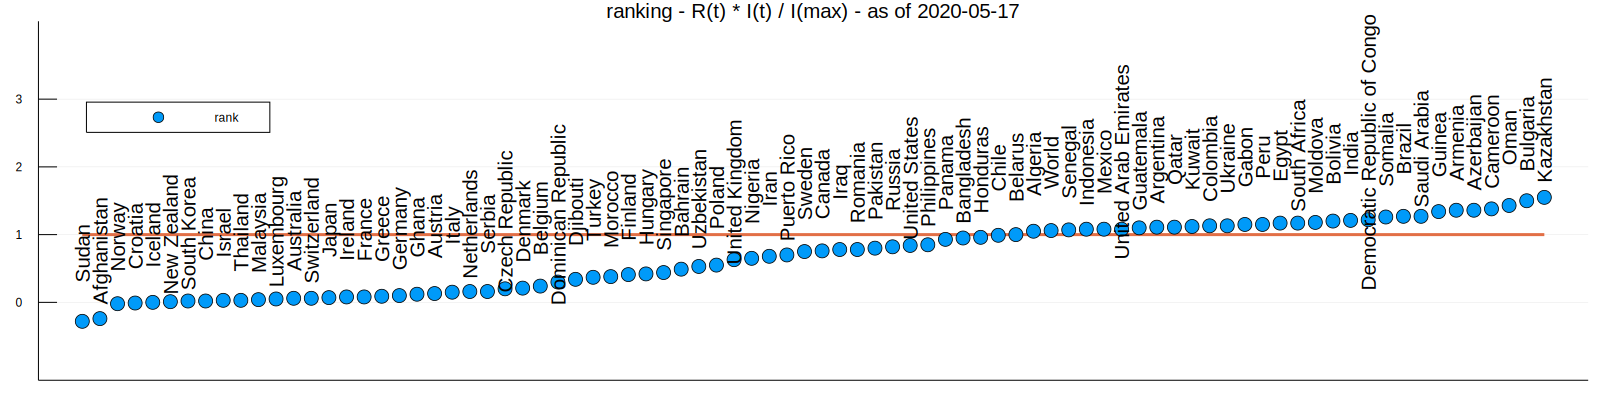

In [18]:
Plots.Font("sans-serif", 10, :hcenter, :center, 0.0, RGB(0.0,0.0,0.0))
myfont = text("").font
myfont.rotation = 90
end_date = maximum(dft[:,:end_date])
fig = plot()
# fig = scatter( (dft[:,:high]+dft[:,:low])/2, 
#     yerror = (dft[:,:high]-dft[:,:low])/2, c=3,
#     m = :circle, ms = 0, markerstrokewidth = 2, label="")
plot!(ones(size(dft)[1]),label="",c=2, lw=3,    
    title="ranking - R(t) * I(t) / I(max) - as of $end_date")
scatter!(dft[:,:rank],markershape=:circle,   
    markersize = 8, c=1, 
    ylims=[-1, 4], yticks = [0.0, 1.0, 2.0, 3.0], xticks = [],
    # series_annotations=text.(dft[:,:country], :middle, 6, :hcenter, :vcenter),
    size=(1600,400),
    label="rank", legend=:topleft)
for j in 1:size(dft)[1]
    annotate!(j,dft[:,:rank][j]+1, dft[:,:country][j], myfont)
end
savefig("plots/ranking")
fig

In [19]:
output_url = "../../HughMurrell.github.io/CoVmodel/RtLiveZA/"
url="https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
data = CSV.read(IOBuffer(HTTP.get(url).body),
            types=[String, String, Float64, Float64, Float64, Float64, Float64, 
                    Float64, Float64, Float64, Float64, Float64, Float64, String])
date_format = DateFormat("dd-mm-yyyy")
data[!,:date] = Date.(data[:,:date],date_format)
data = data[:,[:date, :EC, :FS, :GP, :KZN, :LP, :MP, :NC, :NW, :WC, :total]]
dr = data[1,:date]:Day(1):data[end,:date]
for d in dr
    if ! (d in data[:,:date])
        push!(data,vcat(d, [missing for i in 1:size(data)[2]-2], 0))
    end
end
sort!(data)
latest_date = maximum(data[:,:date])
regions=names(data)[2:end]
rtdf = DataFrame(date=Date[], province=String[], infs=Int64[], rt=Float64[])
fig_inf = plot(legendtitle="latest count",legend=:topleft,ylabel="infectives",
    title="tracking infectives in South Africa \n as of $latest_date")
fig_rts = plot(legendtitle="latest R",legend=:bottomleft,ylabel="R(t)", ylimits = [-1,3],
    title="tracking R(t) in South Africa \n as of $latest_date")
for region in regions
    cases = Impute.interp(data[:,region])   # can impute on total cases (not on new-cases)
    infectives = compute_infectives(diff(cases))
    # infectives = [ cases[i]-cases[i-7] for i in 8:length(cases) ]
    dates = data[9:end,:date]
    max_inf = maximum(infectives)
    if(max_inf<100)
        println("skipping ... ",region," max(inf) = ",max_inf)
    else
        println("processing ... ",region," max(inf) = ",max_inf)
        # smooth_inf = infectives # compute_smooth_infectives(infectives)
        # dates = dates[smooth_inf[:] .> 0]
        # infectives = infectives[smooth_inf[:] .> 0]
        # smooth_inf = smooth_inf[smooth_inf .> 0]
        rt_est = [ 1 + IFP * ((infectives[i+1]-infectives[i])/(infectives[i])) 
                            for i in 1:length(infectives)-1]
        for i in 1:length(dates)
            push!(rtdf,
            [dates[i] "$region" Int64(round(infectives[i])) rt_est[i] ]
            )
        end
        score = round(last(rt_est),digits=2)
        if (region == :total)
            lab = "ZA-$score"
        else
            lab = "$region-$score"
        end
        plot!(fig_rts, dates, rt_est, lw=6,m=:circle,label=lab)
        count = Int64(round(infectives[end],digits=0))
        if (region == :total)
            lab = "ZA-$count"
        else
            lab = "$region-$count"
        end
        plot!(fig_inf, dates, infectives[2:end],lw=6,m=:circle,label=lab)
        # plot!(fig_inf, dates, infectives,lw=6,m=:circle,label=String(region))
    end
end
savefig(fig_rts,output_url*"plots/RtLiveZA")
savefig(fig_inf,output_url*"plots/InfLiveZA")
CSV.write(output_url*"plots/provincial_rts.csv",rtdf)

processing ... EC max(inf) = 793.2412571410814
skipping ... FS max(inf) = 47.51397299855263
processing ... GP max(inf) = 438.9846862021814
processing ... KZN max(inf) = 246.50491748034088
skipping ... LP max(inf) = 61.76215469423237
skipping ... MP max(inf) = 21.95336782182253
skipping ... NC max(inf) = 11.585628431531166
skipping ... NW max(inf) = 29.97689869262491
processing ... WC max(inf) = 4995.345477892212
processing ... total max(inf) = 6610.289088972109


"../../HughMurrell.github.io/CoVmodel/RtLiveZA/plots/provincial_rts.csv"

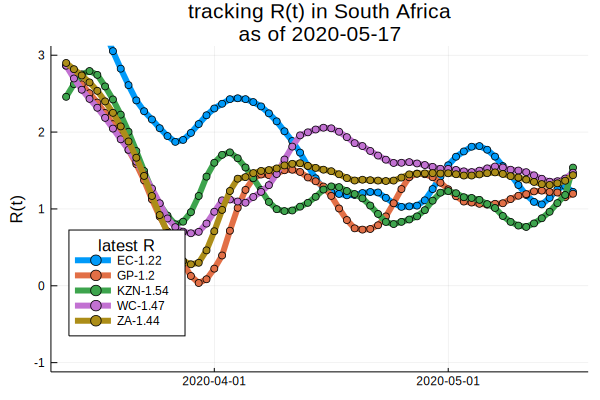

In [20]:
fig_rts

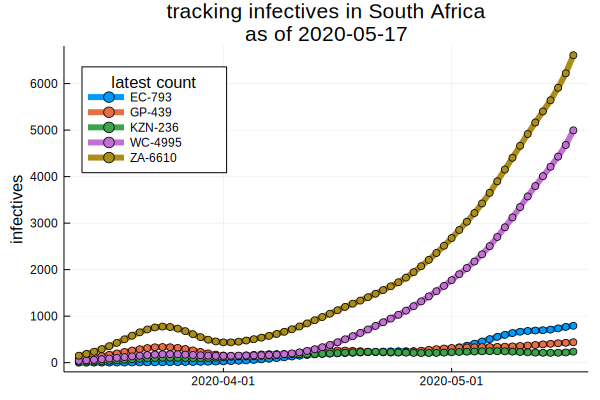

In [21]:
fig_inf

In [22]:
output_url = "../../HughMurrell.github.io/CoVmodel/RtLiveZA/"
url="https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
data = CSV.read(IOBuffer(HTTP.get(url).body),
            types=[String, String, Float64, Float64, Float64, Float64, Float64, 
                    Float64, Float64, Float64, Float64, Float64, Float64, String])
date_format = DateFormat("dd-mm-yyyy")
data[!,:date] = Date.(data[:,:date],date_format)
data = data[:,[:date, :EC, :FS, :GP, :KZN, :LP, :MP, :NC, :NW, :WC, :total]]
dr = data[1,:date]:Day(1):data[end,:date]
for d in dr
    if ! (d in data[:,:date])
        push!(data,vcat(d, [missing for i in 1:size(data)[2]-2], 0))
    end
end
sort!(data)
latest_date = maximum(data[:,:date])
regions=names(data)[2:end]
fig_inf = plot(legendtitle="latest count",legend=:topleft,ylabel="infectives",
    title="tracking infectives in South Africa \n as of $latest_date")
fig_rts = plot(legendtitle="latest R",legend=:bottomleft,ylabel="R(t)", ylimits = [-1,3],
    title="tracking R(t) in South Africa \n as of $latest_date")
    region = :total
    cases = Impute.interp(data[:,region])   # can impute on total cases (not on new-cases)
    println("cases",length(cases))
    infectives = [ cases[i]-cases[i-IFP] for i in IFP+2:length(cases) ]

    onset = estimate_onset(diff(cases),p_delay)
    adj_onset = adjust_onset(onset,p_delay)
    adj_cases = cumsum(adj_onset)
    adj_infectives = [ adj_cases[i]-adj_cases[i-7] for i in 8:length(adj_cases) ]
    
    dates = data[8:end,:date]
    max_inf = maximum(infectives)
    println("processing ... ",region," max(inf) = ",max_inf)
    # smooth_inf = compute_smooth_infectives(infectives)

    # adj_smooth_inf = compute_smooth_infectives(adj_infectives)

    # dates = dates[2:end][smooth_inf[:] .> 0]
    # infectives = infectives[smooth_inf[:] .> 0]
    # smooth_inf = smooth_inf[smooth_inf .> 0]
    # adj_smooth_inf = adj_smooth_inf[smooth_inf .> 0]
    for i in 1:5
        infectives = moving_average(infectives)
    end
    rt_est = [ 1 + IFP * ((infectives[i+1]-infectives[i])/infectives[i]) 
                            for i in 1:length(infectives)-1]
    adj_rt_est = [ 1 + IFP * ((adj_infectives[i+1]-adj_infectives[i])/adj_infectives[i]) 
                            for i in 1:length(adj_infectives)-1]

    est_score = round(rt_est[end],digits=2)
    adj_score = round(adj_rt_est[end],digits=2)
    count = Int64(round(infectives[end],digits=0))
println(length(dates))
println(length(rt_est))
println(length(adj_rt_est))
println(length(infectives))
plot!(fig_rts, dates[3:end], rt_est, lw=6,m=:circle,label="smoothed $est_score")
plot!(fig_rts, dates[3:end], adj_rt_est, lw=6,m=:circle,label="onset adj $adj_score")
plot!(fig_inf, dates[2:end], infectives,lw=6,m=:circle,label="infectives")
plot!(fig_inf, dates[2:end], adj_infectives,lw=6,m=:circle,label="onset adjusted")
   # plot!(fig_inf, dates, adj_smooth_inf,lw=6,m=:circle,label="adjusted")
savefig(fig_rts,output_url*"plots/RtLiveZAtotal")
savefig(fig_inf,output_url*"plots/InfLiveZAtotal")

cases74
processing ... total max(inf) = 5500.0
67
65
65
66


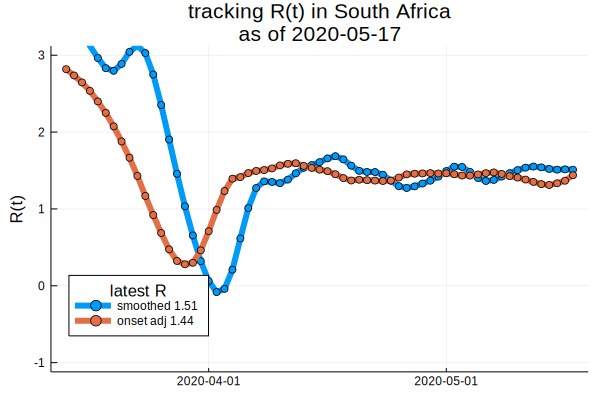

In [23]:
fig_rts

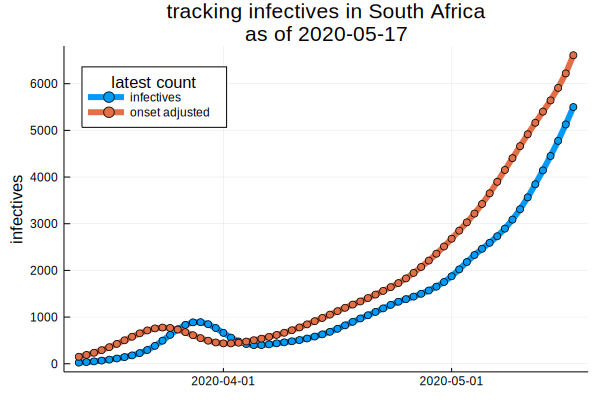

In [24]:
fig_inf